In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [310]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../GVR Historical Data.csv')

In [311]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [312]:
tranformData(df)

In [313]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [314]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109


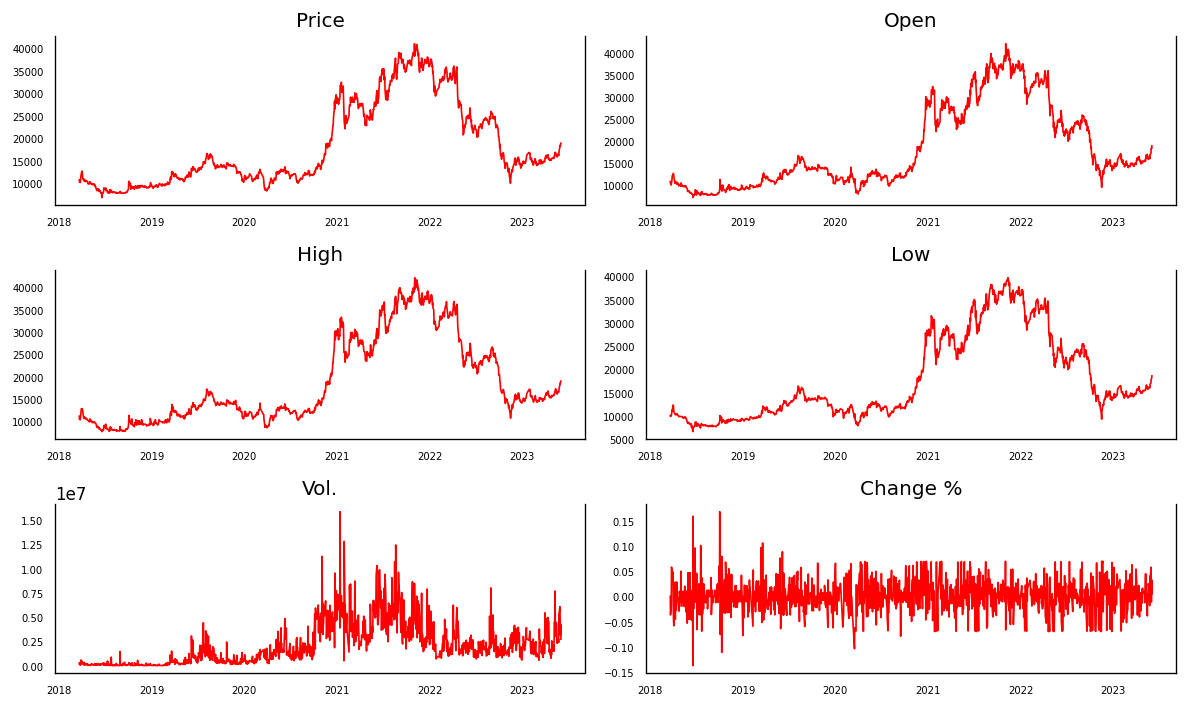

In [315]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [316]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0002,0.0001,0.0037,0.0000,0.0019
Open_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0004
Change %_y,0.0887,0.1597,0.1519,0.0845,0.1563,1.0000


In [317]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  784.03    > 83.9383   =>   True
Open   ::  535.02    > 60.0627   =>   True
High   ::  324.67    > 40.1749   =>   True
Low    ::  129.39    > 24.2761   =>   True
Vol.   ::  39.62     > 12.3212   =>   True
Change % ::  0.17      > 4.1296    =>   False


In [318]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(904, 6)
(258, 6)
(130, 6)


In [319]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [320]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.0151
 No. Lags Chosen       = 12
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.9944. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.9264
 No. Lags Chosen       = 11
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.9934. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [321]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [322]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price"

 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0784
 No. Lags Chosen       = 11
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2188
 No. Lags Chosen       = 10
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2522
 No. 

In [323]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [324]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5016
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.4021
 No. Lags Chosen       = 20
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [325]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  71.15573759135165
BIC :  71.37965237583506
FPE :  7.989967381616244e+30
HQIC:  71.24127009801978 

Lag Order = 2
AIC :  69.4655598789786
BIC :  69.88176742513338
FPE :  1.4740580056489318e+30
HQIC:  69.62455416399726 

Lag Order = 3
AIC :  68.50284664507387
BIC :  69.11168565055748
FPE :  5.628915074421316e+29
HQIC:  68.7354399386341 

Lag Order = 4
AIC :  67.85615884708943
BIC :  68.65796899212877
FPE :  2.948443778397816e+29
HQIC:  68.16248878759514 

Lag Order = 5
AIC :  67.4289496337842
BIC :  68.4240715851141
FPE :  1.923501384969939e+29
HQIC:  67.80915426951064 

Lag Order = 6
AIC :  67.09992077347196
BIC :  68.28869618829388
FPE :  1.3843559805985952e+29
HQIC:  67.55413856423279 

Lag Order = 7
AIC :  66.90968391643527
BIC :  68.29245544639608
FPE :  1.1447204283587678e+29
HQIC:  67.43805373525804 

Lag Order = 8
AIC :  66.73315329765718
BIC :  68.31026459284847
FPE :  9.596807630454048e+28
HQIC:  67.33581443246773 

Lag Order = 9
AIC :  66.47571470834099
BI

In [326]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,75.09,75.12,4.090e+32,75.10
1,71.21,71.44,8.428e+30,71.30
2,69.52,69.94,1.550e+30,69.68
3,68.55,69.17,5.883e+29,68.78
4,67.89,68.71,3.060e+29,68.20
5,67.47,68.48,1.999e+29,67.85
6,67.13,68.34,1.432e+29,67.59
7,66.95,68.34,1.187e+29,67.48
8,66.77,68.36,9.956e+28,67.38
9,66.52,68.31*,7.746e+28,67.20


In [627]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:35:01
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    68.2475
Nobs:                     893.000    HQIC:                   67.1528
Log likelihood:          -36954.1    FPE:                7.42067e+28
AIC:                      66.4757    Det(Omega_mle):     5.18444e+28
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               1.562589        19.509197            0.080           0.936
L1.Price           -0.812326         0.081614           -9.953           0.000
L1.Open             0.024052         0.078217            0.308      

In [628]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

9


array([[-4.880e+02,  9.800e+01, -1.072e+03, -6.810e+02, -4.890e+06,
        -2.270e-02],
       [-2.910e+02,  9.700e+01, -9.700e+01,  3.880e+02,  1.480e+06,
         5.100e-03],
       [-1.950e+02, -1.169e+03, -8.760e+02, -8.750e+02,  9.900e+05,
         2.400e-03],
       [ 3.116e+03,  9.800e+01,  2.921e+03,  5.350e+02,  1.840e+06,
         8.630e-02],
       [-5.405e+03,  4.577e+03, -8.760e+02,  2.920e+02, -4.340e+06,
        -2.176e-01],
       [ 3.360e+03, -7.305e+03, -3.507e+03, -2.920e+02, -9.600e+05,
         2.194e-01],
       [-4.870e+02,  3.605e+03,  2.143e+03,  5.840e+02,  2.370e+06,
        -9.570e-02],
       [ 4.390e+02, -9.900e+01,  9.750e+02, -2.910e+02,  1.600e+05,
         2.390e-02],
       [-6.830e+02,  1.960e+02, -1.073e+03, -1.470e+02, -5.600e+05,
        -2.870e-02]])

In [629]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-11-10,379.450349,-23.737466,1082.728087,-164.032077,2.450792e+06,0.031074
2021-11-11,-48.068773,155.272785,-421.736956,254.742422,-3.339972e+06,-0.020812
2021-11-12,283.207229,-770.884298,-252.095780,219.883043,2.355972e+06,0.021976
2021-11-15,197.935254,1307.572625,809.301482,485.182441,-1.441178e+05,-0.017327
2021-11-16,-1250.769157,-792.076546,-1175.106981,-919.339219,-2.476856e+06,-0.027668
...,...,...,...,...,...,...
2022-11-15,0.339468,0.309682,0.285234,0.376312,-5.143928e+01,0.000005
2022-11-16,0.339468,0.309682,0.285234,0.376312,-5.143939e+01,0.000005
2022-11-17,0.339468,0.309682,0.285234,0.376312,-5.143936e+01,0.000005


In [630]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-11-22,379.450349,-23.737466,1082.728087,-164.032077,2.450792e+06,0.031074
2022-11-23,-48.068773,155.272785,-421.736956,254.742422,-3.339972e+06,-0.020812
2022-11-24,283.207229,-770.884298,-252.095780,219.883043,2.355972e+06,0.021976
2022-11-25,197.935254,1307.572625,809.301482,485.182441,-1.441178e+05,-0.017327
2022-11-28,-1250.769157,-792.076546,-1175.106981,-919.339219,-2.476856e+06,-0.027668
...,...,...,...,...,...,...
2023-05-29,0.336305,0.310067,0.282773,0.376549,-5.851537e+01,0.000005
2023-05-30,0.335981,0.306369,0.282687,0.371751,-4.296306e+01,0.000005
2023-05-31,0.339516,0.307826,0.283849,0.374820,-5.354139e+01,0.000005


In [631]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [632]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [633]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-11-22,39824.450349,40104.262534,40916.728087,39281.967923,5.650792e+06,0.011074
2022-11-23,40057.831925,40625.797854,41284.719218,39518.678268,4.221611e+06,0.003837
2022-11-24,40574.420731,40376.448875,41400.614569,39975.271655,5.148402e+06,0.018574
2022-11-25,41288.944790,41434.672521,42325.811401,40917.047483,5.931076e+06,0.015986
2022-11-28,40752.699693,41700.819621,42075.901253,40939.484093,4.236894e+06,-0.014271
...,...,...,...,...,...,...
2023-05-29,67474.290270,69545.292188,65892.558808,75873.210018,-1.129905e+07,-0.014640
2023-05-30,67715.559286,69799.070198,66109.734584,76187.245006,-1.143076e+07,-0.014470
2023-05-31,67957.167817,70053.156035,66327.194208,76501.654815,-1.156253e+07,-0.014293


In [634]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-11-10,39824.450349,40104.262534,40916.728087,39281.967923,5.650792e+06,0.011074
2021-11-11,40057.831925,40625.797854,41284.719218,39518.678268,4.221611e+06,0.003837
2021-11-12,40574.420731,40376.448875,41400.614569,39975.271655,5.148402e+06,0.018574
2021-11-15,41288.944790,41434.672521,42325.811401,40917.047483,5.931076e+06,0.015986
2021-11-16,40752.699693,41700.819621,42075.901253,40939.484093,4.236894e+06,-0.014271
...,...,...,...,...,...,...
2022-11-15,101116.253646,104546.063512,96009.633535,119128.467741,-2.857599e+07,0.049949
2022-11-16,101400.977180,104839.481529,96263.320802,119490.671582,-2.871429e+07,0.050792
2022-11-17,101686.040181,105133.209228,96517.293304,119853.251735,-2.885263e+07,0.051641


In [635]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,39824.450349,40104.262534,40916.728087,39281.967923,5.650792e+06,0.011074
1,40057.831925,40625.797854,41284.719218,39518.678268,4.221611e+06,0.003837
2,40574.420731,40376.448875,41400.614569,39975.271655,5.148402e+06,0.018574
3,41288.944790,41434.672521,42325.811401,40917.047483,5.931076e+06,0.015986
4,40752.699693,41700.819621,42075.901253,40939.484093,4.236894e+06,-0.014271
...,...,...,...,...,...,...
253,101116.253646,104546.063512,96009.633535,119128.467741,-2.857599e+07,0.049949
254,101400.977180,104839.481529,96263.320802,119490.671582,-2.871429e+07,0.050792
255,101686.040181,105133.209228,96517.293304,119853.251735,-2.885263e+07,0.051641
256,101971.442650,105427.246608,96771.551039,120216.208200,-2.899103e+07,0.052495


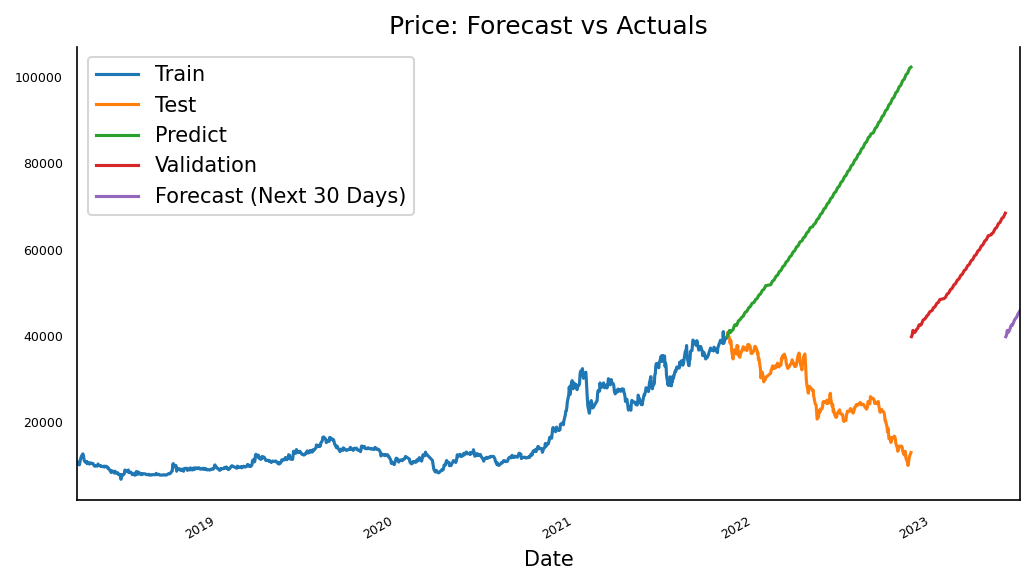

In [636]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [637]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  2.0401
Rmse :  49129.1095
